# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Libraries**

In [0]:
from fastai.vision import *
import pandas as pd
import re
import csv
import glob
import cv2
import seaborn as sns
import zipfile

pd.set_option('display.max_colwidth', -1)
sns.set()

# **Paths**

In [0]:
path_root = '/content/gdrive/Shared drives/Ensemble Learning'
path_text = path_root + '/data'
path_images = '/content/rakuten_images/images'

# **Loading Data**

### Text Data

In [0]:
X_train = pd.read_csv(path_text + '/X_train_update.csv')
y_train = pd.read_csv(path_text + '/Y_train_CVw08PX.csv')
X_test = pd.read_csv(path_text + '/X_test_update.csv')

In [5]:
X_train.head()

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style,"PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class=""vga_style2""><b></b><br>",201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt),NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en &ecirc;tre le vainqueur incontest&eacute;. Mais Sophie s'en m&ecirc;le et chambarde tous ses plans...,278535884,1077757786


### Images

**Reading filenames from folder**

In [0]:
# Download data in a zip file
local_zip = "/content/gdrive/Shared drives/Ensemble Learning/data/images.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
# Unzip the data and save them on the instance
zip_ref.extractall('rakuten_images')
zip_ref.close()

In [0]:
filenames_train = glob.glob(path_images + '/image_train/' + '*.jpg') # reading name of each image
size_name = len(filenames_train)
filenames_train.sort(key=lambda f: int(re.sub('\D', '', f)))

In [8]:
# We create a dataframe with the path and name of each image
image_list = pd.DataFrame(filenames_train, index=[i for i in range(len(filenames_train))],columns =['names'])
image_list.head()

,names
0,/content/rakuten_images/images/image_train/image_67284_product_365202.jpg
1,/content/rakuten_images/images/image_train/image_234234_product_184251.jpg
2,/content/rakuten_images/images/image_train/image_234381_product_184752.jpg
3,/content/rakuten_images/images/image_train/image_414480_product_853823.jpg
4,/content/rakuten_images/images/image_train/image_482710_product_929166.jpg


**Displaying one image to test paths**

In [0]:
# We load one image using the library OpenCV
img = cv2.imread(path_images + '/image_train/image_' + str(X_train.imageid.iloc[5]) + '_product_' + str(X_train.productid.iloc[5]) + '.jpg')

In [10]:
# We check the shape of images
img.shape

(500, 500, 3)

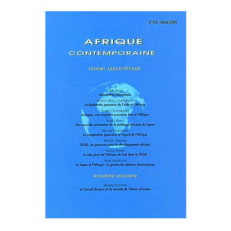

In [11]:
# We plot an image
plt.imshow(img)
plt.axis('off')
plt.show()

**Creating dataframe to associate filenames with labels**

In [0]:
# dataframe with filenames
# We built a dataframe which contains both the image name and the associated label
df_images = pd.DataFrame(
              [path_images + '/image_train/image_' + str(X_train.imageid.iloc[i]) + '_product_' + str(X_train.productid.iloc[i]) + '.jpg' for i in range(len(filenames_train))],
              index=[i for i in range(len(filenames_train))],
              columns=['images']
          )   

In [13]:
df_images.head()

,images
0,/content/rakuten_images/images/image_train/image_1263597046_product_3804725264.jpg
1,/content/rakuten_images/images/image_train/image_1008141237_product_436067568.jpg
2,/content/rakuten_images/images/image_train/image_938777978_product_201115110.jpg
3,/content/rakuten_images/images/image_train/image_457047496_product_50418756.jpg
4,/content/rakuten_images/images/image_train/image_1077757786_product_278535884.jpg


In [0]:
# concatenating X_train and the newdataframe which contains the filenames
df_train = pd.concat([X_train, df_images], axis=1)

In [0]:
# binding df_train and y_train
df_train['labels'] = y_train['prdtypecode']

In [0]:
# dropping non necessary columns
df_train.drop(['Unnamed: 0', 'designation', 'description', 'productid', 'imageid'], axis=1, inplace=True)

**Exporting the new dataframe to csv**

In [0]:
# We saved the new dataframe under csv file to use it easily for the CNN
df_train.dropna(inplace=True)
df_train.to_csv (r'/content/gdrive/Shared drives/Ensemble Learning/data/csv_labels/labels.csv', index = False, header=True)

**Reading the exported dataframe**

In [0]:
# We read the saved dataframe to make sure we are able to read it correctly
df_train = pd.read_csv('/content/gdrive/Shared drives/Ensemble Learning/data/csv_labels/labels.csv')

In [19]:
# We plot the first 5 lines of the dataset we are going to use later on
df_train.head()

,images,labels
0,/content/rakuten_images/images/image_train/image_1263597046_product_3804725264.jpg,10
1,/content/rakuten_images/images/image_train/image_1008141237_product_436067568.jpg,2280
2,/content/rakuten_images/images/image_train/image_938777978_product_201115110.jpg,50
3,/content/rakuten_images/images/image_train/image_457047496_product_50418756.jpg,1280
4,/content/rakuten_images/images/image_train/image_1077757786_product_278535884.jpg,2705


In [0]:
# This function allows us to extract the name of each image, located at the end of the path
def extract_image_name(row):
  return row.split('/')[-1]

In [0]:
# We apply this function to each row
df_train.images = df_train.images.apply(extract_image_name)

# **CNN**

In [0]:
np.random.seed(42)

# We create labels from the previous dataframe df_train
data = ImageDataBunch.from_df(Path('/content/rakuten_images/images/image_train'),
                              df_train,
                              valid_pct=0.3,
                              label_col="labels",
                              size=(100,100), 
                              bs = 100) \
                .normalize(imagenet_stats)

In [23]:
data

ImageDataBunch;

Train: LabelList (59442 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
10,2280,50,1280,2280
Path: /content/rakuten_images/images/image_train;

Valid: LabelList (25474 items)
x: ImageList
Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100),Image (3, 100, 100)
y: CategoryList
2905,1281,2060,1280,2280
Path: /content/rakuten_images/images/image_train;

Test: None

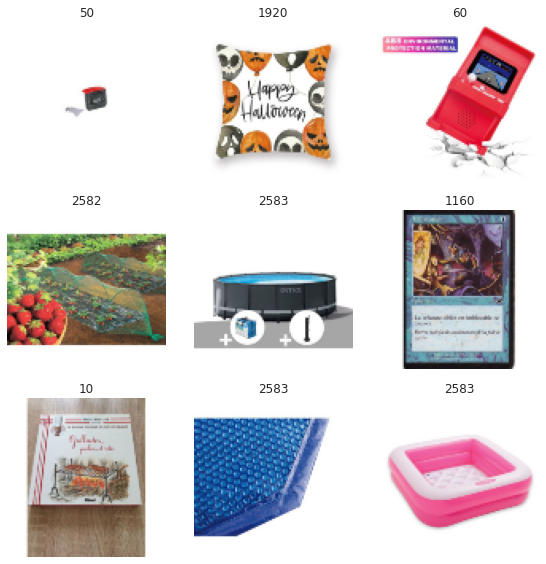

In [24]:
# show images
data.show_batch(rows=3, figsize=(8,8))

In [25]:
# classes
data.classes

[10,
 40,
 50,
 60,
 1140,
 1160,
 1180,
 1280,
 1281,
 1300,
 1301,
 1302,
 1320,
 1560,
 1920,
 1940,
 2060,
 2220,
 2280,
 2403,
 2462,
 2522,
 2582,
 2583,
 2585,
 2705,
 2905]

In [26]:
# number of classes
data.c

27

# **Transfer Learning - RESNET 50**

### Save the best model

In [0]:
# This class allows us to save the best model when training multiple epochs
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best accuracy {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Accuracy is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

### Unfreezing the last layer (Classifier)

In [0]:
# We define the metric we want to use for our classification task: weighted f1 score
fbeta = FBeta(average='weighted')

In [0]:
# We load the RESNET-50 model for transfer learning to retrain the classifier only
learn = cnn_learner(data, 
                    models.resnet50,       
                    metrics=fbeta,callback_fns=SaveBestModel
                    )

In [0]:
# Unfreeze classifier and last convolutional layer
#learn.freeze_to(-2)

In [0]:
# Fit and validate the model
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,f_beta,time
epoch,train_loss,valid_loss,f_beta,time
0,2.063974,1.812438,0.460109,1:27:53
1,1.746367,1.604607,0.510930,1:29:24


Save the best accuracy 0.46011
Save the best accuracy 0.51093


In [0]:
learn.save('/content/gdrive/Shared drives/Ensemble Learning/best_model')

# **Feature Extraction using CNN**

The aim of this final part is to extract the Feature Maps of images. This would have the advantage to make the classifier more powerful. In fact, taking into account Feature Maps is a way to get more characteristics for each product

In [0]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.resnet50(pretrained=True)

class ResnetFeature(nn.Module):
            def __init__(self):
                super(ResnetFeature, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.children())[:-1]
                   # *list(original_model.features.children())
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = ResnetFeature()

In [0]:
model_dict = model.state_dict()
pretrained_dict = learn.load(Path('/content/gdrive/Shared drives/Ensemble Learning/best_model'))
# 1. filter out unnecessary keys
#pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
#model_dict.update(pretrained_dict)
# 3. load the new state dict
#model.load_state_dict(model_dict)
model.eval()

ResnetFeature(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [0]:
import cv2
from PIL import Image
from torchvision import transforms
def featuremap(path_image):
  print(path_image)
  img = Image.open(path_image)
  #img = cv2.imread(path_image)
  trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
  img = trans(img)
  img = img.unsqueeze(0) 
  output = model(img)
  featuremap = output.squeeze(0)
  return featuremap

In [0]:
images_train = os.listdir(path_images + '/image_train')
images_test = os.listdir(path_images + '/image_test')

In [0]:
# We finally export the feature maps using CSV
with open('/content/gdrive/Shared drives/Ensemble Learning/data/feature_extraction.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_train:
      writer.writerow(featuremap(str(path_images+'/image_train/')+"/"+name).detach().numpy().tolist())

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/content/rakuten_images/images/image_train//image_1261424285_product_3898727695.jpg
/content/rakuten_images/images/image_train//image_938404749_product_16979909.jpg
/content/rakuten_images/images/image_train//image_937776939_product_197193965.jpg
/content/rakuten_images/images/image_train//image_1243382563_product_3773714453.jpg
/content/rakuten_images/images/image_train//image_1168515928_product_2861077061.jpg
/content/rakuten_images/images/image_train//image_1249534534_product_3819979218.jpg
/content/rakuten_images/images/image_train//image_1240731009_product_3748207824.jpg
/content/rakuten_images/images/image_train//image_1225886439_product_532978677.jpg
/content/rakuten_images/images/image_train//image_1203142505_product_3267041561.jpg
/content/rakuten_images/images/image_train//image_1318479059_product_92626768.jpg
/content/rakuten_images/images/image_train//image_1273314704_product_3992560046.jpg
/conte

KeyboardInterrupt: ignored

In [0]:
with open('/content/gdrive/Shared drives/Ensemble Learning/data/feature_extraction_test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for name in images_test:
      writer.writerow(featuremap(str(path_images+'/image_test/')+"/"+name).detach().numpy().tolist())

/content/rakuten_images/images/image_test//image_1161947374_product_2743752299.jpg
/content/rakuten_images/images/image_test//image_1257602834_product_3881714672.jpg
/content/rakuten_images/images/image_test//image_1102674984_product_1805032728.jpg
/content/rakuten_images/images/image_test//image_960793975_product_17920105.jpg
/content/rakuten_images/images/image_test//image_849257806_product_80604782.jpg
/content/rakuten_images/images/image_test//image_1008015386_product_435891140.jpg


KeyboardInterrupt: ignored

In [0]:
feature_maps_train = pd.read_csv('/content/gdrive/Shared drives/Ensemble Learning/data/feature_extraction.csv',header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,[[0.2636895179748535]],[[0.33839520812034607]],[[0.16233563423156738]],[[0.06588201224803925]],[[0.3741692900657654]],[[0.2465430498123169]],[[0.26487991213798523]],[[0.013199372217059135]],[[0.637348473072052]],[[0.0421544685959816]],[[0.027700789272785187]],[[0.09487533569335938]],[[0.025359395891427994]],[[0.04554077610373497]],[[0.0496794767677784]],[[0.11118824034929276]],[[0.06401564180850983]],[[0.08261808753013611]],[[0.21852830052375793]],[[0.1876831203699112]],[[0.49641597270965576]],[[0.03442836552858353]],[[0.16812600195407867]],[[0.2609800100326538]],[[0.09818504750728607]],[[0.18884994089603424]],[[0.11217861622571945]],[[0.6462166905403137]],[[0.05161005258560181]],[[0.10946446657180786]],[[0.16201326251029968]],[[1.1331913471221924]],[[0.12662068009376526]],[[0.1027938723564148]],[[0.15797850489616394]],[[0.04128066450357437]],[[0.18467648327350616]],[[0.30594903230667114]],[[0.47544723749160767]],[[0.3990175724029541]],...,[[0.18151415884494781]],[[0.12431395798921585]],[[0.8219887614250183]],[[0.42542746663093567]],[[0.014373636804521084]],[[0.10808572173118591]],[[0.2107277810573578]],[[0.11974260956048965]],[[0.1121387705206871]],[[0.12124083936214447]],[[1.5479322671890259]],[[0.09697673469781876]],[[0.2715098559856415]],[[0.1477060168981552]],[[0.09429161995649338]],[[0.4139562249183655]],[[0.18324558436870575]],[[0.04103349521756172]],[[0.26736369729042053]],[[0.11345785856246948]],[[0.2646319568157196]],[[0.04505698010325432]],[[0.0060653178952634335]],[[0.19118380546569824]],[[0.2807980179786682]],[[0.0414656437933445]],[[0.14400333166122437]],[[0.03903261572122574]],[[0.4416097402572632]],[[0.07877475023269653]],[[0.3245215117931366]],[[0.06529591977596283]],[[0.11980810016393661]],[[0.3970964848995209]],[[0.21192419528961182]],[[0.05304756388068199]],[[0.036624111235141754]],[[0.12026511132717133]],[[0.3489238917827606]],[[0.18828953802585602]]
1,[[0.521232008934021]],[[0.2710374891757965]],[[0.09882961958646774]],[[0.1126335859298706]],[[0.550356388092041]],[[0.5137079954147339]],[[0.04814201220870018]],[[0.2861018776893616]],[[0.4330592751502991]],[[0.3483947813510895]],[[0.097967728972435]],[[0.28938281536102295]],[[0.36887943744659424]],[[0.19255319237709045]],[[0.1281810998916626]],[[0.1848517656326294]],[[0.1143866777420044]],[[0.09004353731870651]],[[0.15960001945495605]],[[0.20121100544929504]],[[0.4745444655418396]],[[0.3092499375343323]],[[0.3537944555282593]],[[0.35415300726890564]],[[0.3754156827926636]],[[0.08798503130674362]],[[0.1665578931570053]],[[0.4473598003387451]],[[0.27506473660469055]],[[0.13733555376529694]],[[0.17520219087600708]],[[0.48152798414230347]],[[0.14123788475990295]],[[0.5251514911651611]],[[0.141712486743927]],[[0.05722133070230484]],[[0.1980803906917572]],[[0.13597559928894043]],[[0.7478123307228088]],[[0.328164279460907]],...,[[0.6370947957038879]],[[0.2074458748102188]],[[0.982488214969635]],[[0.2617653012275696]],[[0.052808891981840134]],[[0.4986500144004822]],[[0.762824296951294]],[[0.1968804895877838]],[[0.36897969245910645]],[[0.27760353684425354]],[[0.703346848487854]],[[0.05430764704942703]],[[0.3841015696525574]],[[0.08001192659139633]],[[0.3833959996700287]],[[0.4147530794143677]],[[0.14350973069667816]],[[0.10645192116498947]],[[1.1341341733932495]],[[0.61316978931427]],[[0.3802995979785919]],[[0.11704271286725998]],[[0.16415327787399292]],[[0.11042812466621399]],[[0.41943618655204773]],[[0.2604897618293762]],[[0.393326997756958]],[[0.3384832739830017]],[[0.801227331161499]],[[0.16032461822032928]],[[0.754501223564148]],[[0.24591943621635437]],[[0.27450427412986755]],[[0.15223197638988495]],[[0.3092726767063141]],[[0.06484535336494446]],[[0.

In [0]:
feature_maps_test = pd.read_csv('/content/gdrive/Shared drives/Ensemble Learning/data/feature_extraction_test.csv',header=None)